In [1]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [2]:
#f = r.TFile("./pileupCorrection/NtriplePileupCorrected.root")
#f = r.TFile("./data/results_1MissingFile_FullVsTrunc.root")
f = r.TFile("./pileupCorrection/NtriplePileupCorrected_1MissingFile.root")

f.ls()

TFile**		./pileupCorrection/NtriplePileupCorrected_1MissingFile.root	
 TFile*		./pileupCorrection/NtriplePileupCorrected_1MissingFile.root	
  KEY: TCanvas	c1;1	c1


In [3]:
c = f.Get("c1")
print([x for x in c.GetListOfPrimitives()])

[<ROOT.TFrame object ("TFrame") at 0x7fffeac74ef0>, <ROOT.TH2D object ("NtriplePileup") at 0x7fffeac7a2a0>, <ROOT.TPaveText object ("title") at 0x7fffeacb47a0>]


In [4]:
h1 = c.GetPrimitive("NtriplePileup").Clone()
h1.SetDirectory(0)

binLow = h1.GetYaxis().FindBin(1700)
binHigh = h1.GetYaxis().FindBin(3100)

w1 = h1.ProjectionX("",binLow,binHigh).Clone("w1")

In [5]:
f2 = r.TFile("./pileupCorrection/NtriplePileupCorrected_trunc.root")
f2.ls()

TFile**		./pileupCorrection/NtriplePileupCorrected_trunc.root	
 TFile*		./pileupCorrection/NtriplePileupCorrected_trunc.root	
  KEY: TCanvas	c1_n3;1	c1_n3


In [6]:
c = f2.Get("c1_n3")
print([x for x in c.GetListOfPrimitives()])

[<ROOT.TFrame object ("TFrame") at 0x7fffec4c2870>, <ROOT.TH2D object ("NtriplePileup") at 0x7fffec46fa80>, <ROOT.TPaveText object ("title") at 0x7fffec4c23a0>]


In [7]:
h2 = c.GetPrimitive("NtriplePileup").Clone()
h2.SetDirectory(0)

binLow = h2.GetYaxis().FindBin(1700)
binHigh = h2.GetYaxis().FindBin(3100)

w2 = h2.ProjectionX("",binLow,binHigh).Clone("w2")
w2.SetLineColor(2)

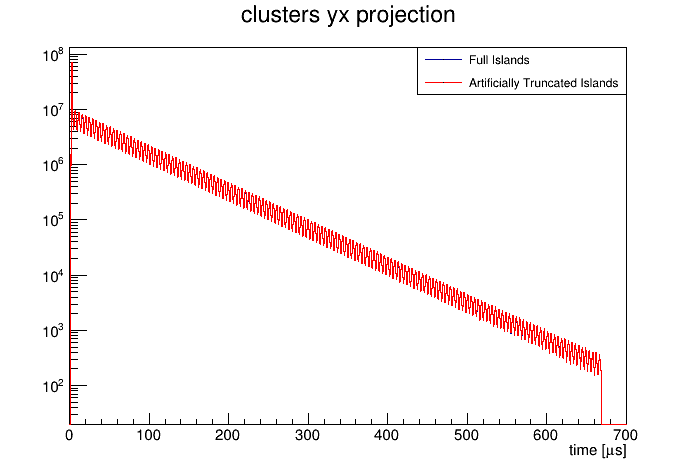

In [8]:
c = r.TCanvas()
w1.Draw("hist")
w2.Draw("SAME hist")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(w1,"Full Islands")
leg.AddEntry(w2,"Artificially Truncated Islands")
leg.Draw()

c.SetLogy()
c.Draw()

In [9]:
#time bounds in microseconds within which to do all the fits
fitBoundLow = 30
fitBoundHigh = 650

---

# Lets first do a full wiggle fit of the full islands

### 5 Parameter Fit

In [10]:
# blinded instance
getBlinded = Blinders(FitType.Omega_a, 'Oh wow we have to choose a new blinding phrase, huh? This is exciting!')
def blinded_wiggle(x, p):
    norm  = p[0]
    life  = p[1]
    asym  = p[2]
    R     = p[3]
    phi   = p[4]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
#    omega = myBlinder.paramToFreq(R) unblind version
    
    return norm * math.exp(-time/life) * (1 - asym*math.cos(omega*time + phi))

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [11]:
funcFull = r.TF1("funcFull", blinded_wiggle, fitBoundLow,fitBoundHigh,5)
funcFull.SetParNames('N','#tau','A','R','#phi')
funcFull.SetParameters(7000000,64.4,0.4,-100,0)
funcFull.SetParLimits(4,-0.001 - 2*math.pi,2*math.pi+0.001)
funcFull.SetLineColor(2)
funcFull.SetNpx(2000)

Sarting fit: 1
Sarting fit: 2
 FCN=12046.8 FROM MINOS     STATUS=SUCCESSFUL     36 CALLS         556 TOTAL
                     EDM=7.30104e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  N            7.74163e+06   3.01550e+02  -9.88637e-03  -3.40917e-12
   2  #tau         6.44235e+01   1.41359e-03  -5.61998e-09   5.98600e-06
   3  A            3.72376e-01   2.91901e-05  -2.10003e-09   2.90718e-06
   4  R           -4.61659e+01   8.78695e-01   1.42002e-05   2.77729e-08
   5  #phi        -1.06075e+00   1.43992e-04   1.43992e-04   6.13569e-04
 FCN=12046.8 FROM MINOS     STATUS=SUCCESSFUL     47 CALLS         277 TOTAL
                     EDM=7.08453e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   

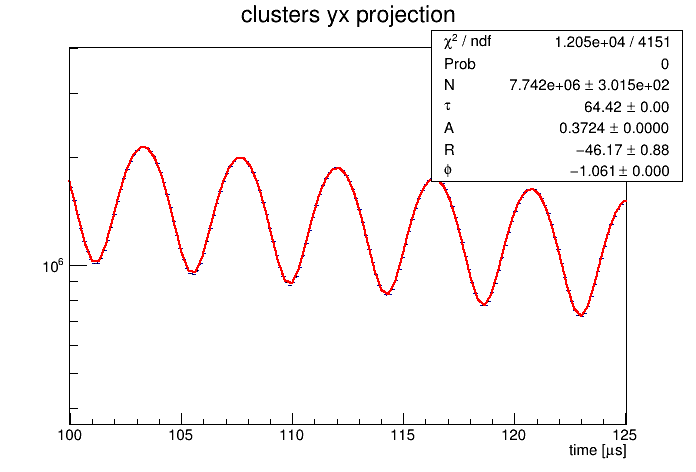

In [12]:
residualsFull_5Param = w1.Clone() # this will be filled with the fit residuals later
c2 = r.TCanvas()

for fit in range(2):
    print("Sarting fit:", fit+1)
    w1.Fit("funcFull","REM")
    
w1.Draw()

c2.cd(2)
ding =  w1.Clone()
ding.GetXaxis().SetRangeUser(100,125)
ding.Draw()

r.gPad.SetLogy()
c2.Draw()

### 5-Param Residuals FFT

In [13]:
def fourierXformWiggle( wigglePlot, fitFunction, fitBoundLow, fitBoundHigh, title ):
    c3 = r.TCanvas()
    residualsFull_5Param = wigglePlot.Clone() 
    nBins = residualsFull_5Param.GetSize() - 2 #total number of bins excluding over/underflow
    print(nBins)
    residVec = []
    for i in range(nBins):
        binCenterX = wigglePlot.GetXaxis().GetBinCenter(i)
        if (binCenterX > fitBoundLow and binCenterX < fitBoundHigh):
            residVec.append( (binCenterX, wigglePlot.GetBinContent(i) - fitFunction.Eval(binCenterX) ) )
            residualsFull_5Param.SetBinContent(i, wigglePlot.GetBinContent(i) - fitFunction.Eval(binCenterX))
        else:
            residualsFull_5Param.SetBinContent(i, 0)

    print(len(residVec),[residVec[i] for i in range(5)])
    centers, bins = zip(*residVec)
    htest = r.TH1D("htest","htest",len(residVec),centers[0],centers[len(residVec)-1])
    for i,ding in enumerate(bins):
        htest.SetBinContent(i, ding)

    residualsFull_5Param.Delete()
    residualsFull_5Param = htest
    nBins = residualsFull_5Param.GetSize() - 2 #total number of bins excluding over/underflow

    #apply a windows function to try to get rid of the imaginary peaks
    welchVec = []
    for i in range(nBins):
        unwindowed = residualsFull_5Param.GetBinContent(i)
        welch = 1 #- ( ( i - (nBins - 1) / 2) / ((nBins - 1) / 2) )**2
        welchVec.append(welch)
        residualsFull_5Param.SetBinContent(i, unwindowed *  welch)

    residualsFull_5Param.Draw()
    residualsFull_5Param.GetXaxis().SetRangeUser(30,700)
    residualsFull_5Param.SetTitle("(Windowed) Residuals of the Fit")
    c3.Draw()    

    hxform = r.TH1D()
    hxform = 0
    r.TVirtualFFT.SetTransform(0)
    hxform = residualsFull_5Param.FFT(hxform,"MAG P")
    hxform.SetTitle( title )
    #NOTE: for "real" frequencies you have to divide the x-axes range with the range of your function
    #    y-axes has to be rescaled by a factor of 1/SQRT(n) to be right: this is not done automatically!
    normXform = hxform.GetEntries()
    hxform.Scale(1/normXform)
    c2 = r.TCanvas()
    c2.cd()
    #c2.SetLogy()
    hxform.GetXaxis().SetTitle("Frequency (MHz)")
    hxform.GetYaxis().SetTitle("Arb. Units")
    hxform.Draw("HIST P0 L")
    #c2.Draw()

    Npart = residualsFull_5Param.GetSize() - 2
    minBinCenter = residualsFull_5Param.GetXaxis().GetBinCenter(0)
    maxBinCenter = residualsFull_5Param.GetXaxis().GetBinCenter(Npart)

    capT = maxBinCenter - minBinCenter
    print(Npart, capT, minBinCenter, maxBinCenter)
    deltaT = capT/Npart #microseconds
    deltaF = 1/capT
    print(deltaT, deltaF)

    deltaTns = deltaT*1000 #nanoseconds
    limmaxHz = (1/(deltaTns*math.pow(10.0,-9)))
    limmaxMHz = limmaxHz / math.pow(10.0,6)

    limmax = 2*deltaF*Npart #400-25
    print(limmax,limmaxMHz)
    #hxform.GetXaxis().SetLimits(0,limmax)
    nbins = residualsFull_5Param.GetSize() - 2
    hxform.SetBins(Npart,0,limmaxMHz)
    hxform.GetXaxis().SetRangeUser(0,limmaxMHz/2)
    #hxform.GetXaxis().SetRangeUser(0,1.4)

    #c2.SetLogy()
    #c2.Draw()
    #c2.Print("./images/FullIslands_5ParamResiduals.png")
    #c2.Print("./images/FullIslands_5ParamResiduals.root")
    
    return hxform;

In [14]:
ding = fourierXformWiggle( w1, funcFull, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 5-Parameter Fit [Full Islands]" )
residuals5paramXform_FullIslands = ding.Clone()

4692
4156 [(30.0618073316283, -11785.131274975836), (30.21099744245524, -6974.587092158385), (30.36018755328218, -12168.29650493525), (30.50937766410912, -15553.32171499962), (30.65856777493606, -7254.369729550555)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


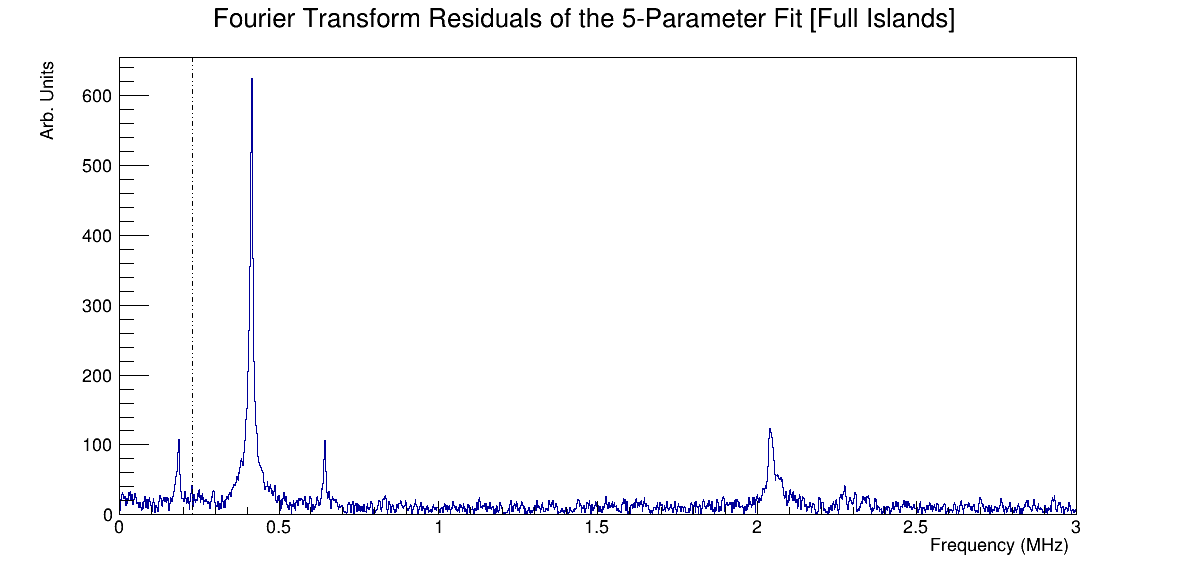

In [15]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
residuals5paramXform_FullIslands.Draw("hist")

f_omega_a = r.TLine(0.23,0.0000001,0.23,655)
f_omega_a.SetLineStyle(8)
f_omega_a.Draw("SAME")


c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


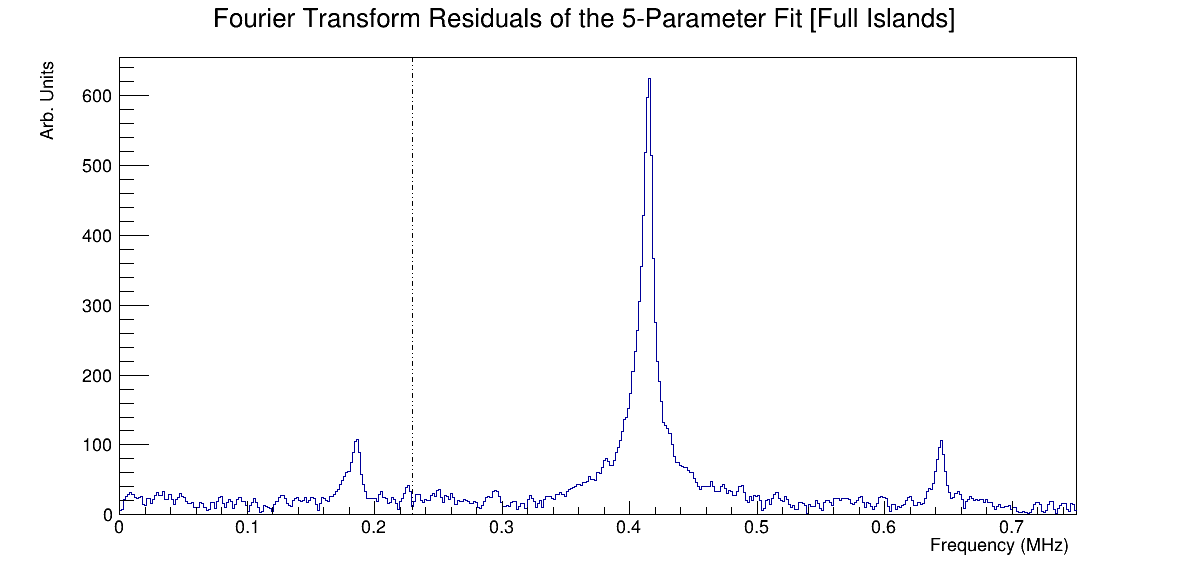

In [16]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,0.75)
residuals5paramXform_FullIslands.Draw("hist")

f_omega_a = r.TLine(0.23,0.0000001,0.23,655)
f_omega_a.SetLineStyle(8)
f_omega_a.Draw("SAME")


c.Draw()

---

### 13-Parameter Fit

In [17]:
def blinded_wiggle_cbo(x, p):
    norm     = p[0]
    life     = p[1]
    asym     = p[2]
    R        = p[3]
    phi      = p[4]
    A1       = p[5]
    A2       = p[6]
    A3       = p[7]
    lifeCBO  = p[8]
    omegaCBO = p[9]
    phiCBO1  = p[10]
    phiCBO2  = p[11]
    phiCBO3  = p[12]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
    
    cCBO = 1-math.exp(-time/lifeCBO)*A1*math.cos(omegaCBO*time + phiCBO1)
    ACBO = asym * (1 - math.exp(-time/lifeCBO) * A2 * math.cos(omegaCBO*time + phiCBO2))
    phiCBO = phi + math.exp(-time/lifeCBO)*A3*math.cos(omegaCBO*time + phiCBO3)
    
    return norm * math.exp(-time/life) * cCBO * (1 - ACBO*math.cos(omega*time + phiCBO))

In [18]:
func13Full = r.TF1("func13Full", blinded_wiggle_cbo, fitBoundLow, fitBoundHigh,13)
func13Full.SetParNames('N','#tau','A',
                   'R','#phi','A_{1}',
                   'A_{2}','A_{3}','#tau_{CBO}',
                   '#omega_{CBO}','#phi_{CBO - 1}')
func13Full.SetParName(11,'#phi_{CBO - 2}')
func13Full.SetParName(12,'#phi_{CBO - 3}')
func13Full.SetParLimits(8,0.0000001,100000000) #Avoid divide by 0 error
#func13Full.SetParLimits(10,-6.3,6.3)
#func13Full.SetParLimits(11,-6.3,6.3)
#func13Full.SetParLimits(12,-6.3,6.3)


#initial guesses, then updated with the first round of fit results
func13Full.SetParameters(100000, 64.32689658986958, -0.41149191856871803, 
                     -11.31981267111425, -4.201648334505292, -0.666502391530784, 
                     0.6927259503578, -0.38908021438317, 200, 
                     2.5, 0.4745581246420292)
func13Full.SetParameter(11, 6.299934663288357)
func13Full.SetParameter(12, 0.28579778778899545)
for i in range(4):
    func13Full.SetParameter(i, funcFull.GetParameter(i))

func13Full.SetLineColor(2)
func13Full.SetNpx(2000)

Starting Fit: 1
     Parameters from fit 1 :
      ChiSq / NDF =  1.925152416224199
       7740009.854869704 +/- 102.124901272488
       64.42889600355674 +/- 0.00048625318374523796
       0.37239961431447766 +/- 2.6838813430368137e-05
       -50.913476511360514 +/- 0.8511206514902453
       -7.3437368967137555 +/- 0.00013630848859644441
       -0.01945111223389009 +/- 0.000569452861825195
       0.006477857077227159 +/- 0.0024686366969830656
       0.004544319249905811 +/- 0.0027506971763621695
       21.26309183733352 +/- 0.21959606910648688
       2.5954720291206055 +/- 0.0017194759469034162
       -6.703964125406466 +/- 0.07099193659707322
       -0.949135986723836 +/- 0.2308239365132985
       -4.095283511972266 +/- 0.1046003798189934
Starting Fit: 2
     Parameters from fit 2 :
      ChiSq / NDF =  1.2164835515282753
       7742112.446375642 +/- 301.8643974160291
       64.42190275975011 +/- 0.0014143080443642618
       0.3724064778878778 +/- 2.9290389990485956e-05
       -44.718

Warning in <Fit>: Abnormal termination of minimization.


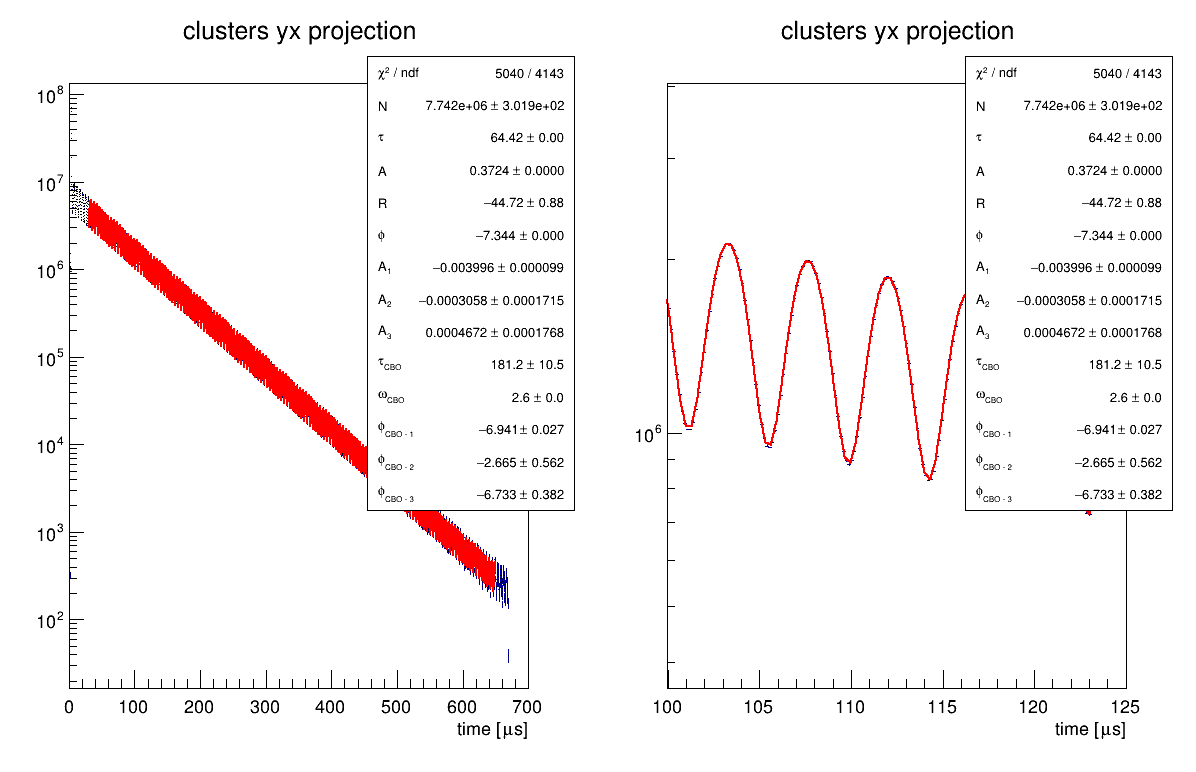

In [19]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)
w1_13 = w1.Clone()
w1_13.GetXaxis().UnZoom()

residuals13 = w1_13.Clone() # this will be filled with the fit residuals later

for i in range(2): #the fit won't converge the first time. Don't look at me like that!
    print("Starting Fit:",i+1)
    w1_13.Fit("func13Full","REMB")
    print("     Parameters from fit", i+1,":")
    print("      ChiSq / NDF = ", func13Full.GetChisquare() / func13Full.GetNDF() )
    for i in range(13):
        print( "      ", func13Full.GetParameter(i) ,"+/-", func13Full.GetParError(i) )

w1_13.Draw()

c2.cd(2)
ding13 =  w1_13.Clone()
ding13.GetXaxis().SetRangeUser(100,125)
ding13.Draw()

r.gPad.SetLogy()
c2.Draw()

In [20]:
parameters13Full = []
for i in range(13):
    parameters13Full.append( (func13Full.GetParameter(i) , func13Full.GetParError(i)) )
#print(parameters13)
par13,parErr13 = zip(*parameters13Full)
print(par13)

(7742112.446375642, 64.42190275975011, 0.3724064778878778, -44.71899919916622, -7.344262884499996, -0.003995662687254881, -0.000305791458809049, 0.00046716197490302475, 181.19149487469045, 2.5999554521301365, -6.941348080688821, -2.6647653145640073, -6.732880126959866)


In [21]:
ding = fourierXformWiggle( w1, func13Full, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 13-Parameter Fit [Full Islands]" )
residuals13paramXform_FullIslands = ding.Clone()
residuals13paramXform_FullIslands.SetLineColor(6)

4692
4156 [(30.0618073316283, -4159.820431112312), (30.21099744245524, 4630.933997187763), (30.36018755328218, 990.1556755844504), (30.50937766410912, -3098.0199788846076), (30.65856777493606, 2749.6695131473243)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


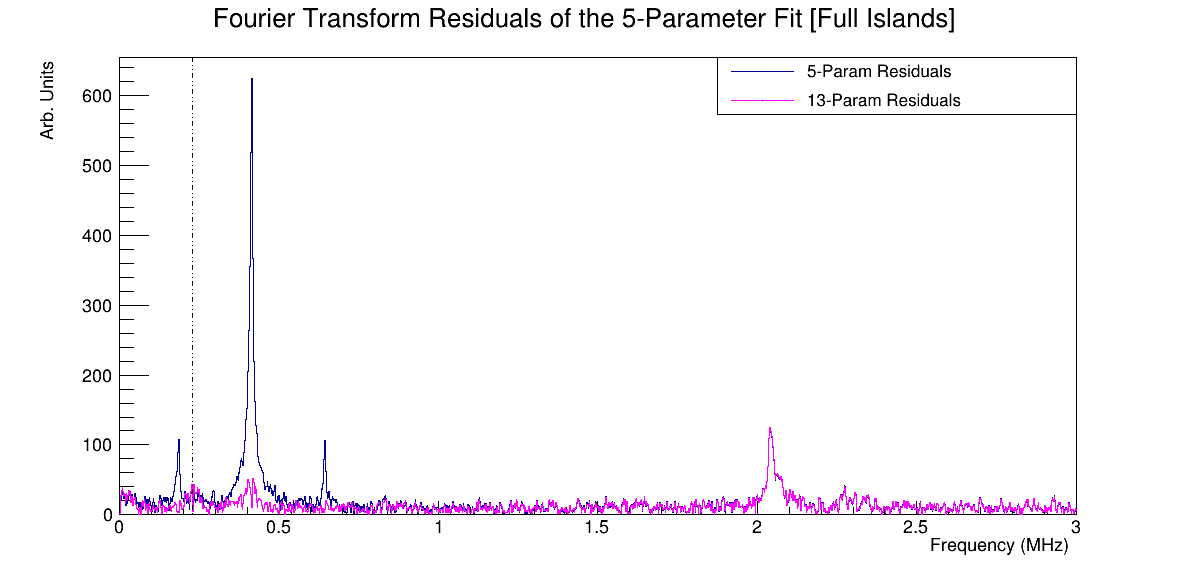

In [22]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

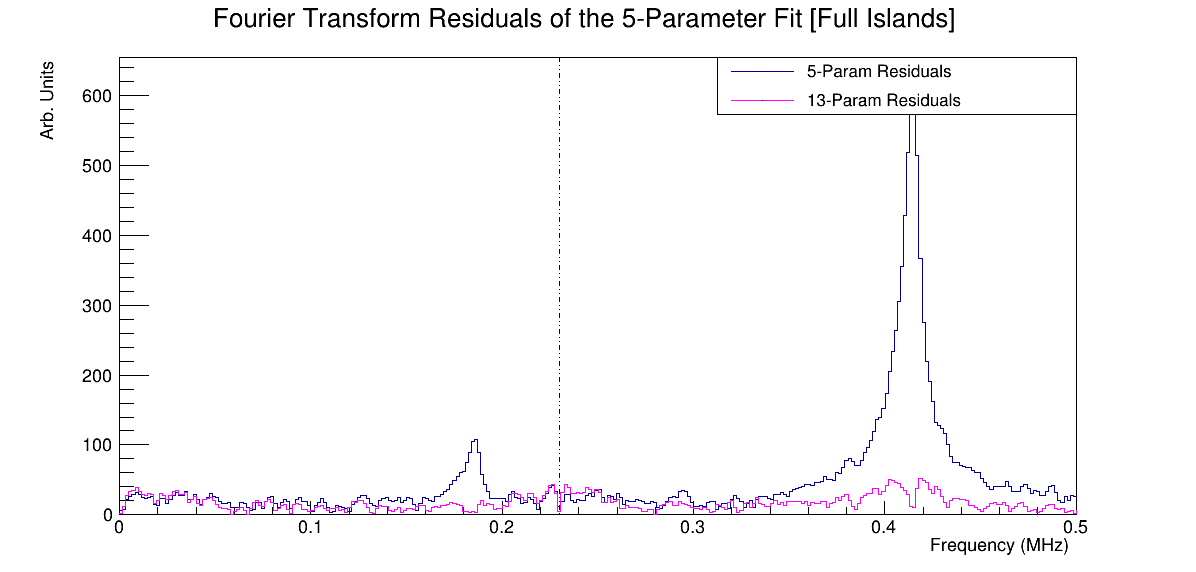

In [26]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,.5)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

---

### 17-Parameter Fit with vertical waist term

In [27]:
def blinded_wiggle_cbo_vw(x, p):
    norm     = p[0]
    life     = p[1]
    asym     = p[2]
    R        = p[3]
    phi      = p[4]
    A1       = p[5]
    A2       = p[6]
    A3       = p[7]
    lifeCBO  = p[8]
    omegaCBO = p[9]
    phiCBO1  = p[10]
    phiCBO2  = p[11]
    phiCBO3  = p[12]
    Avw      = p[13]
    lifeVW   = p[14]
    omegaVW  = p[15]
    phiVW    = p[16]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
    
    cCBO = 1-math.exp(-time/lifeCBO)*A1*math.cos(omegaCBO*time + phiCBO1)
    ACBO = asym * (1 - math.exp(-time/lifeCBO) * A2 * math.cos(omegaCBO*time + phiCBO2))
    phiCBO = phi + math.exp(-time/lifeCBO)*A3*math.cos(omegaCBO*time + phiCBO3)
    cVW = 1 - Avw*math.exp(-time/lifeVW)*math.cos(omegaVW*time + phiVW)
    
    return norm * math.exp(-time/life) * cCBO * cVW * (1 - ACBO*math.cos(omega*time + phiCBO))

In [28]:
func17Full = r.TF1("func17Full", blinded_wiggle_cbo_vw,  fitBoundLow, fitBoundHigh,17)
func17Full.SetParNames('N','#tau','A',
                   'R','#phi','A_{1}',
                   'A_{2}','A_{3}','#tau_{CBO}',
                   '#omega_{CBO}','#phi_{CBO - 1}')
func17Full.SetParName(11,'#phi_{CBO - 2}')
func17Full.SetParName(12,'#phi_{CBO - 3}')
func17Full.SetParName(13,'A_{VW}')
func17Full.SetParName(14,'#tau_{VW}')
func17Full.SetParName(15,'#omega_{VW}')
func17Full.SetParName(16,'#phi_{VW}')
func17Full.SetParLimits(8,0.0000001,100000000) #Avoid divide by 0 error
func17Full.SetParLimits(14,0.0000001,100000000) #Avoid divide by 0 error
#func17Full.SetParLimits(10,-6.3,6.3) 
#func17Full.SetParLimits(11,-6.3,6.3)
#func17Full.SetParLimits(12,-6.3,6.3)
#func17Full.SetParLimits(16,-6.3,6.3)

#initial guesses, then updated with the first round of fit results
for i in range(13):
    func17Full.SetParameter(i, func13Full.GetParameter(i))
func17Full.SetParameter(13, 0.2)
func17Full.SetParameter(14, 30)
func17Full.SetParameter(15, 12.83)
func17Full.SetParameter(16, 0)

#func17Full.SetParameter(9, 2.307 ) #omega_cbo


func17Full.SetLineColor(4)
func17Full.SetNpx(2000)

Starting Fit: 1
     Parameters from fit 1 :
      ChiSq / NDF =  1.1032978745950692
       7742110.300986515 +/- 301.87814448086453
       64.42191121512886 +/- 0.001414340527010117
       0.3724065111870979 +/- 2.929171238552707e-05
       -44.74114887797924 +/- 0.8810132420087327
       -7.344257789284808 +/- 0.00014472202812410817
       -0.004000802978135579 +/- 9.893740549765105e-05
       0.00030670576504267775 +/- 0.00017160393222901527
       -0.0004580362278264072 +/- 0.0001769565986440117
       180.77812972147257 +/- 10.450032286724024
       2.5999457527060086 +/- 0.0003502510159464614
       -6.94047641601885 +/- 0.0266632830028098
       19.3349501366691 +/- 0.5605110396576211
       -3.598873798696422 +/- 0.3902578572637164
       0.004110411900082321 +/- 0.0006803591564745014
       30.713136922679812 +/- 3.5127086545072537
       12.830107246452023 +/- 0.004098952522155704
       -7.575958562902626 +/- 0.18048729351001755
Starting Fit: 2
     Parameters from fit 2 :
 

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


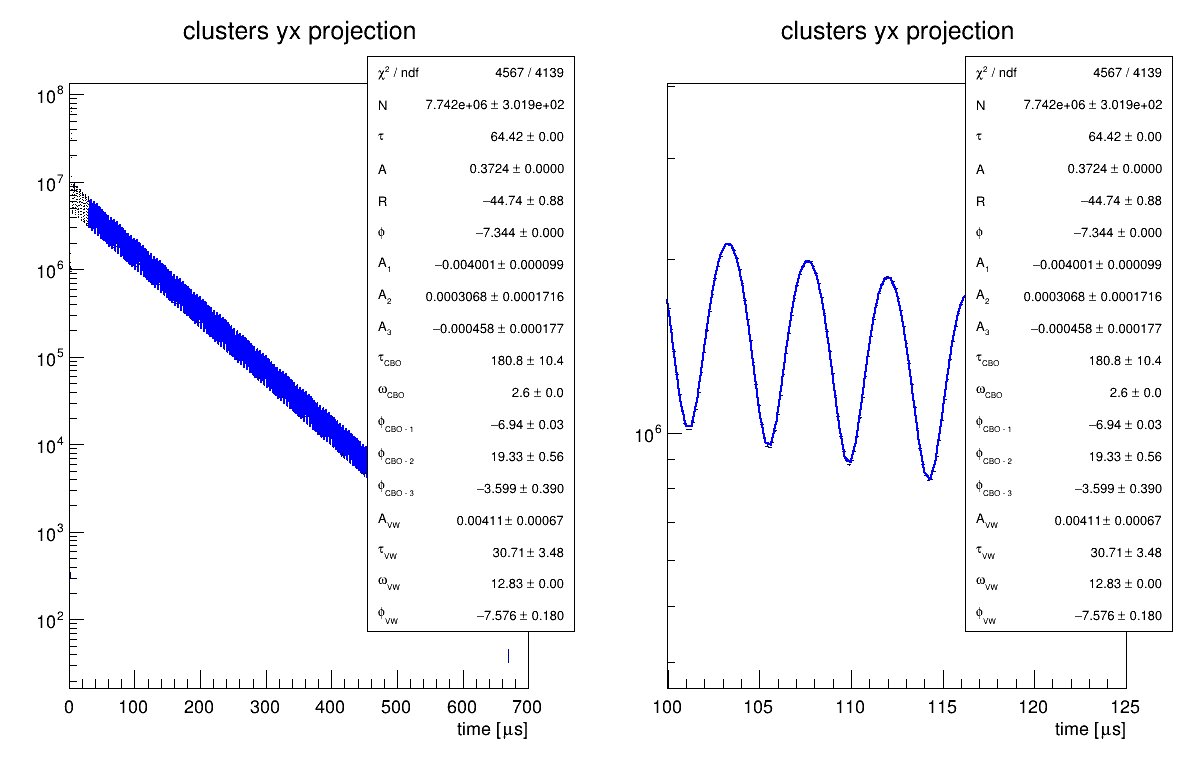

In [29]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)
w1_17 = w1.Clone()
w1_17.GetXaxis().UnZoom()

residuals17 = w1_17.Clone() # this will be filled with the fit residuals later

for i in range(2): #the fit won't converge the first time. Don't look at me like that!
    print("Starting Fit:",i+1)
    w1_17.Fit("func17Full","REMB")
    print("     Parameters from fit", i+1,":")
    print("      ChiSq / NDF = ", func17Full.GetChisquare() / func17Full.GetNDF() )
    for i in range(17):
        print( "      ", func17Full.GetParameter(i) ,"+/-", func17Full.GetParError(i) ) 

w1_17.Draw()

c2.cd(2)
ding17 =  w1_17.Clone()
ding17.GetXaxis().SetRangeUser(100,125)
ding17.Draw()

r.gPad.SetLogy()
c2.Draw()

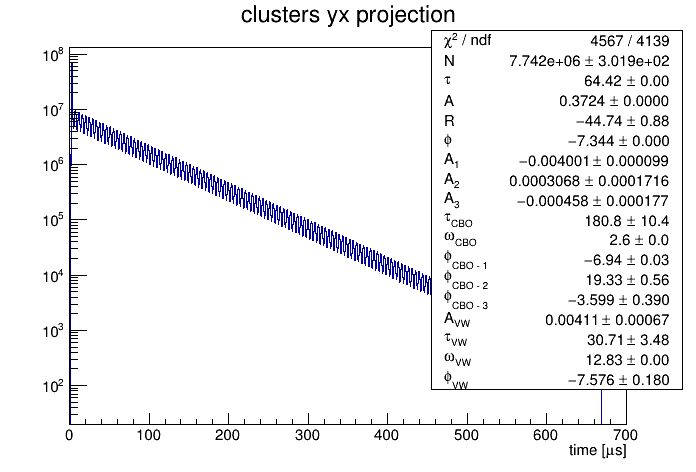

In [30]:
c = r.TCanvas()
w1_17.Draw("hist")
c.SetLogy()
c.Draw()

In [31]:
ding = fourierXformWiggle( w1, func17Full, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 17-Parameter Fit [Full Islands]" )
residuals17paramXform_FullIslands = ding.Clone()
residuals17paramXform_FullIslands.SetLineColor(3)

4692
4156 [(30.0618073316283, -683.6243322072551), (30.21099744245524, -2679.0003124810755), (30.36018755328218, 2663.571361232549), (30.50937766410912, 2042.5782209164463), (30.65856777493606, -1737.0637728013098)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: out_MAG P (Potential memory leak).


In [32]:
parameters17Full = []
for i in range(17):
    parameters17Full.append( (func17Full.GetParameter(i) , func17Full.GetParError(i)) )
#print(parameters13)
par17,parErr17 = zip(*parameters17Full)
print(par17)

(7742110.275896916, 64.4219110956378, 0.3724065113196168, -44.741035301455355, -7.344257777183986, -0.004000797873539495, 0.00030675419394190833, -0.00045797499373061856, 180.7772818552509, 2.599945747249106, -6.9404769098597034, 19.334923157875096, -3.5988884379985056, 0.0041104030297519824, 30.713015353258616, 12.830107253590496, -7.575956906886894)


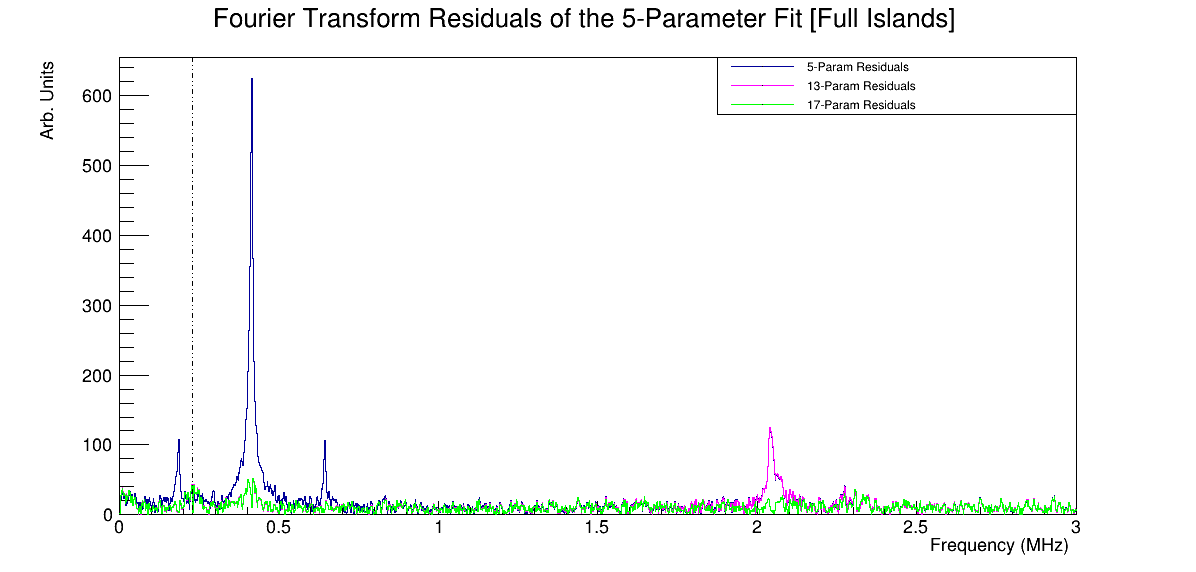

In [33]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")
residuals17paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


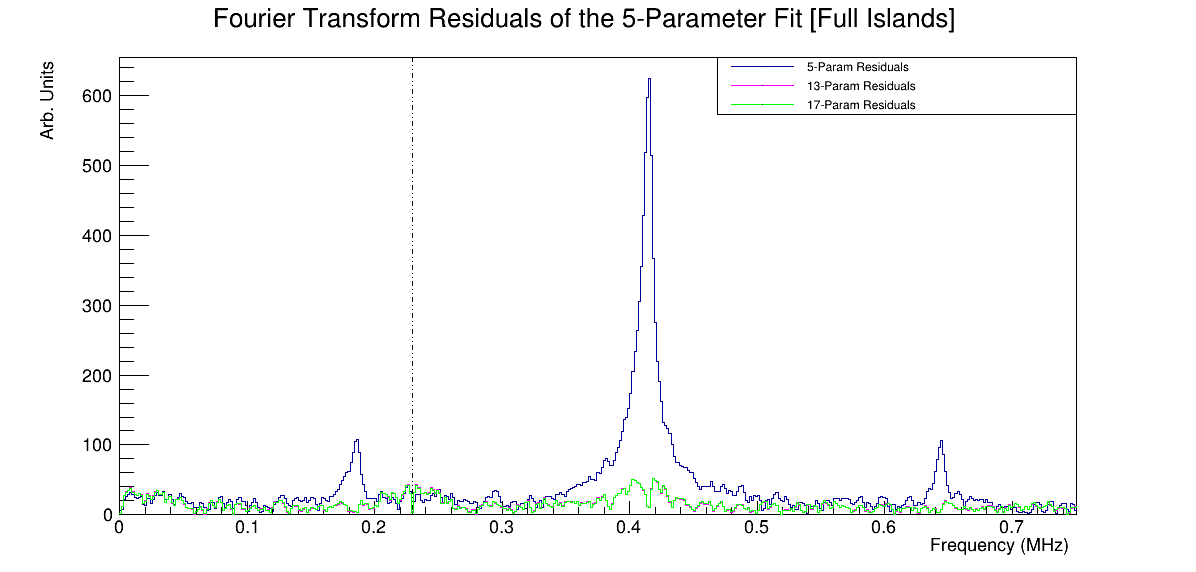

In [34]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,0.75)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")
residuals17paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


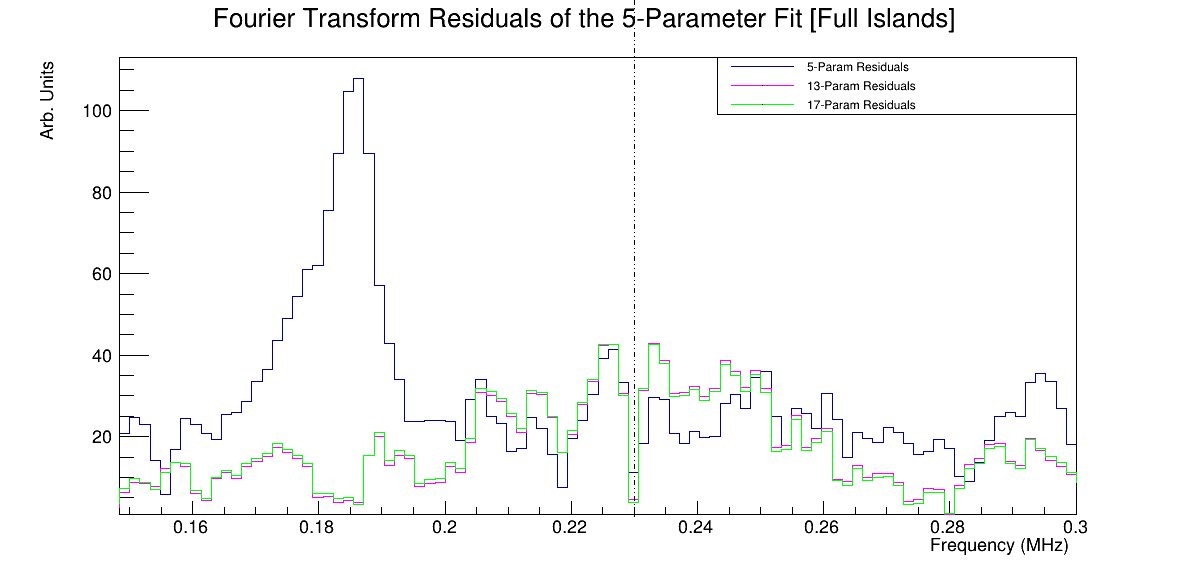

In [35]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0.15,0.3)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")
residuals17paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

---

### 18-Parameter Fit with all this and a K<sub>loss</sub> term

In [36]:
f_Kloss = r.TFile("./Kloss/kloss_firstTry.root")
f.ls()

TFile**		./pileupCorrection/NtriplePileupCorrected_1MissingFile.root	
 TFile*		./pileupCorrection/NtriplePileupCorrected_1MissingFile.root	
  OBJ: TH1D		clusters yx projection : 0 at: 0x7fffec4788d0
  OBJ: TH1D	w1	clusters yx projection : 0 at: 0x7fffec4765f0
  KEY: TCanvas	c1;1	c1


In [37]:
c_Kloss = f_Kloss.Get("c1_n4")
print([x for x in c_Kloss.GetListOfPrimitives()])

[<ROOT.TFrame object ("TFrame") at 0x7fa0bd0152b0>, <ROOT.TH1D object ("KlossInt") at 0x7fa0b5595270>, <ROOT.TPaveText object ("title") at 0x7fa0b5886e50>]


In [38]:
KlossHist = c_Kloss.GetPrimitive("KlossInt").Clone()
KlossHist.SetDirectory(0)

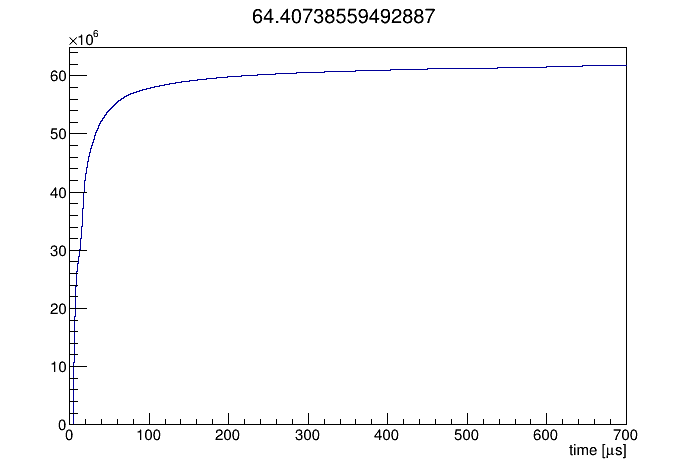

In [39]:
c = r.TCanvas()
KlossHist.Draw()
c.Draw()

In [40]:
def blinded_wiggle_cbo_vw_Kloss(x, p):
    norm     = p[0]
    life     = p[1]
    asym     = p[2]
    R        = p[3]
    phi      = p[4]
    A1       = p[5]
    A2       = p[6]
    A3       = p[7]
    lifeCBO  = p[8]
    omegaCBO = p[9]
    phiCBO1  = p[10]
    phiCBO2  = p[11]
    phiCBO3  = p[12]
    Avw      = p[13]
    lifeVW   = p[14]
    omegaVW  = p[15]
    phiVW    = p[16]
    Kloss    = p[17]
    
    time  = x[0]
    omega = getBlinded.paramToFreq(R)
    
    cCBO = 1-math.exp(-time/lifeCBO)*A1*math.cos(omegaCBO*time + phiCBO1)
    ACBO = asym * (1 - math.exp(-time/lifeCBO) * A2 * math.cos(omegaCBO*time + phiCBO2))
    phiCBO = phi + math.exp(-time/lifeCBO)*A3*math.cos(omegaCBO*time + phiCBO3)
    cVW = 1 - Avw*math.exp(-time/lifeVW)*math.cos(omegaVW*time + phiVW)
    
    return ( norm * math.exp(-time/life) * cCBO * cVW * (1 - ACBO*math.cos(omega*time + phiCBO)) 
            * (1 - Kloss*KlossHist.GetBinContent(KlossHist.FindBin(time))) )

In [41]:
func18Full = r.TF1("func18Full", blinded_wiggle_cbo_vw_Kloss,  fitBoundLow, fitBoundHigh,18)
func18Full.SetParNames('N','#tau','A',
                   'R','#phi','A_{1}',
                   'A_{2}','A_{3}','#tau_{CBO}',
                   '#omega_{CBO}','#phi_{CBO - 1}')
func18Full.SetParName(11,'#phi_{CBO - 2}')
func18Full.SetParName(12,'#phi_{CBO - 3}')
func18Full.SetParName(13,'A_{VW}')
func18Full.SetParName(14,'#tau_{VW}')
func18Full.SetParName(15,'#omega_{VW}')
func18Full.SetParName(16,'#phi_{VW}')
func18Full.SetParName(17,'K_{loss}')
func18Full.SetParLimits(8,0.0000001,100000000) #Avoid divide by 0 error
func18Full.SetParLimits(14,0.0000001,100000000) #Avoid divide by 0 error
#func17Full.SetParLimits(10,-6.3,6.3) 
#func17Full.SetParLimits(11,-6.3,6.3)
#func17Full.SetParLimits(12,-6.3,6.3)
#func17Full.SetParLimits(16,-6.3,6.3)

#initial guesses, then updated with the first round of fit results
for i in range(17):
    func18Full.SetParameter(i, func17Full.GetParameter(i))
#func18Full.SetParameter(13, 0.2)
#func18Full.SetParameter(14, 30)
#func18Full.SetParameter(15, 12.83)
func18Full.SetParameter(17, 10**(-10))

#func17Full.SetParameter(9, 2.307 ) #omega_cbo


func18Full.SetLineColor(4)
func18Full.SetNpx(2000)

Starting Fit: 1
     Parameters from fit 1 :
      ChiSq / NDF =  1.0938999112944134
       7773741.488476518 +/- 5009.754108997947
       64.43401109114357 +/- 0.0023795635467176745
       0.3724131161563516 +/- 2.9309500951389227e-05
       -44.84866818227962 +/- 0.88100972138645
       -7.344233348231814 +/- 0.00014475793911676612
       -0.004025368528375544 +/- 9.958049647326001e-05
       0.00027346395985181554 +/- 0.00017231230081889905
       -0.00041121665157373204 +/- 0.00017771631967058895
       178.91282463885696 +/- 10.269221187297887
       2.5999289963851844 +/- 0.0003500899727108404
       -6.93952835717314 +/- 0.026586377999193604
       19.387958594480075 +/- 0.6313346610216702
       -3.500566584046205 +/- 0.4365035408838689
       0.004118216420282937 +/- 0.0007024670675376101
       30.658020400222657 +/- 3.609845755647708
       12.830483826529901 +/- 0.004129342147490637
       -7.595873604417327 +/- 0.1816683502852396
       7.748427131808016e-11 +/- 1.21996492

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2


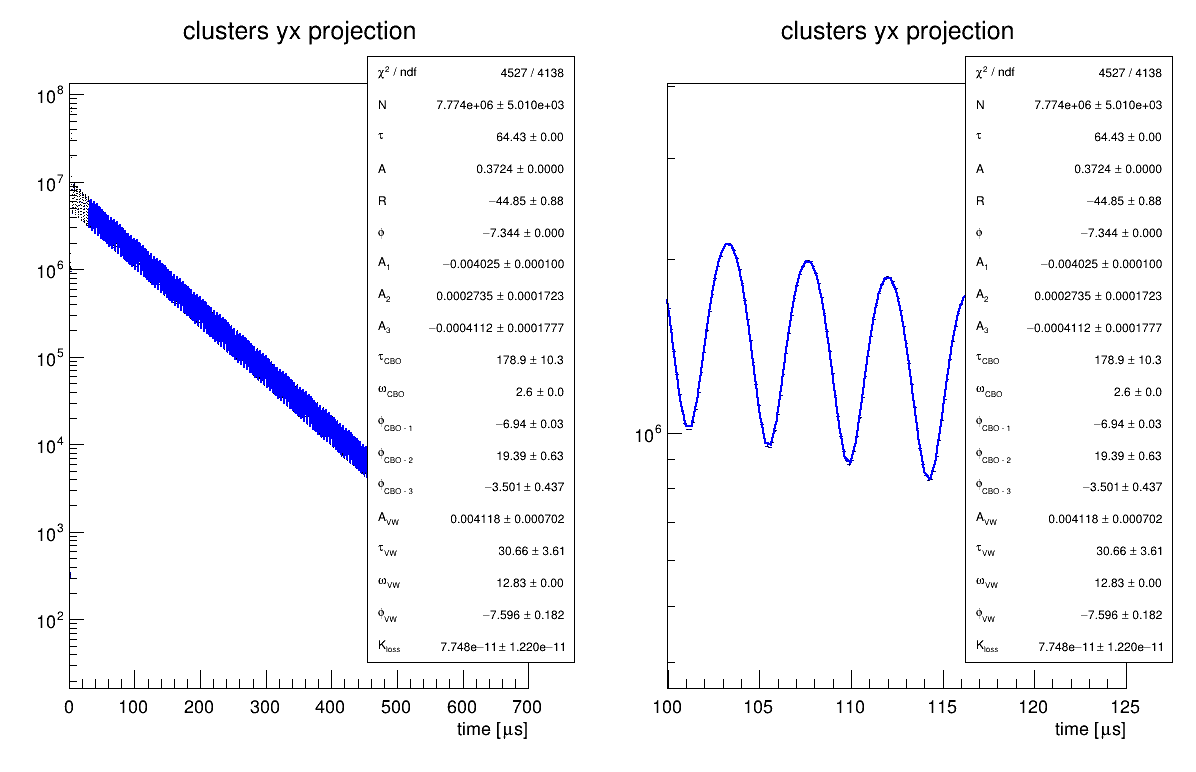

In [42]:
c2 = r.TCanvas("c2","c2",1200,800)
c2.Divide(2,1)
c2.cd(1)
r.gPad.SetLogy()

r.gStyle.SetOptFit(111)
w1_18 = w1.Clone()
w1_18.GetXaxis().UnZoom()

residuals18 = w1_18.Clone() # this will be filled with the fit residuals later

for i in range(1): #the fit won't converge the first time. Don't look at me like that!
    print("Starting Fit:",i+1)
    w1_18.Fit("func18Full","REMB")
    print("     Parameters from fit", i+1,":")
    print("      ChiSq / NDF = ", func18Full.GetChisquare() / func18Full.GetNDF() )
    for i in range(18):
        print( "      ", func18Full.GetParameter(i) ,"+/-", func18Full.GetParError(i) ) 

w1_18.Draw()

c2.cd(2)
ding18 =  w1_18.Clone()
ding18.GetXaxis().SetRangeUser(100,125)
ding18.Draw()

r.gPad.SetLogy()
c2.Draw()

In [43]:
ding = fourierXformWiggle( w1, func18Full, fitBoundLow, fitBoundHigh, "Fourier Transform Residuals of the 18-Parameter Fit [Full Islands]" )
residuals18paramXform_FullIslands = ding.Clone()
residuals18paramXform_FullIslands.SetLineColor(46)

4692
4156 [(30.0618073316283, -2457.084523024969), (30.21099744245524, -4305.253212665208), (30.36018755328218, 1168.5536084817722), (30.50937766410912, 804.5308983293362), (30.65856777493606, -2860.7220707796514)]
4156 619.8849104859335 29.987230224976962 649.8721407109105
0.1491542133026789 0.0016132026817947396
13.408940691077875 6.704470345538938


In [44]:
parameters18Full = []
for i in range(18):
    parameters18Full.append( (func18Full.GetParameter(i) , func18Full.GetParError(i)) )
#print(parameters13)
par18,parErr18 = zip(*parameters18Full)
print(par18)

(7773741.488476518, 64.43401109114357, 0.3724131161563516, -44.84866818227962, -7.344233348231814, -0.004025368528375544, 0.00027346395985181554, -0.00041121665157373204, 178.91282463885696, 2.5999289963851844, -6.93952835717314, 19.387958594480075, -3.500566584046205, 0.004118216420282937, 30.658020400222657, 12.830483826529901, -7.595873604417327, 7.748427131808016e-11)


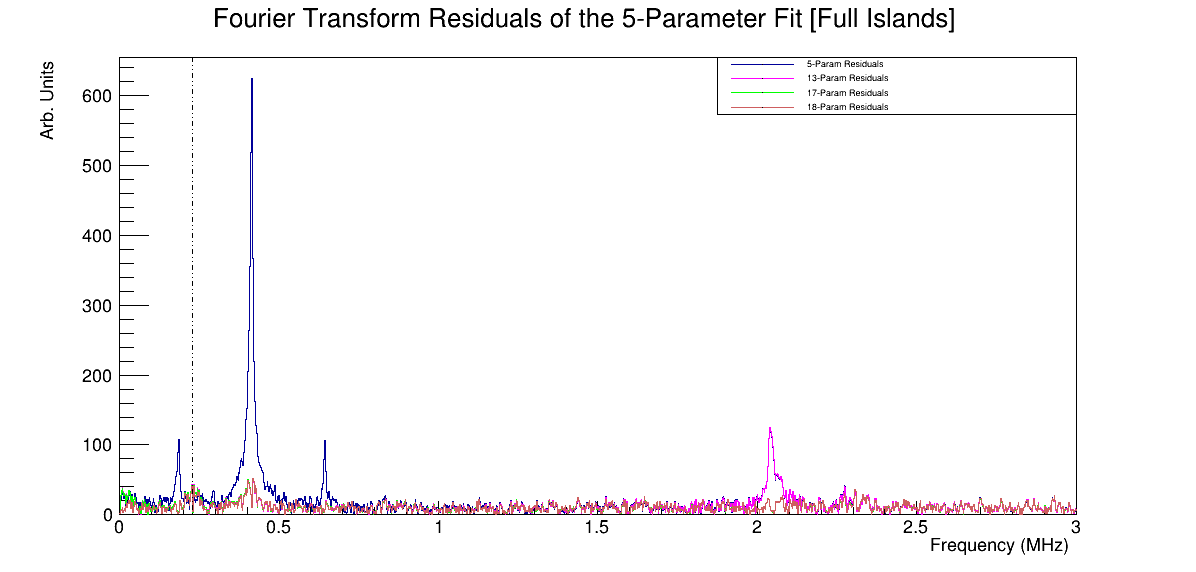

In [45]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")
residuals17paramXform_FullIslands.Draw("hist same")
residuals18paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.AddEntry(residuals18paramXform_FullIslands,"18-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


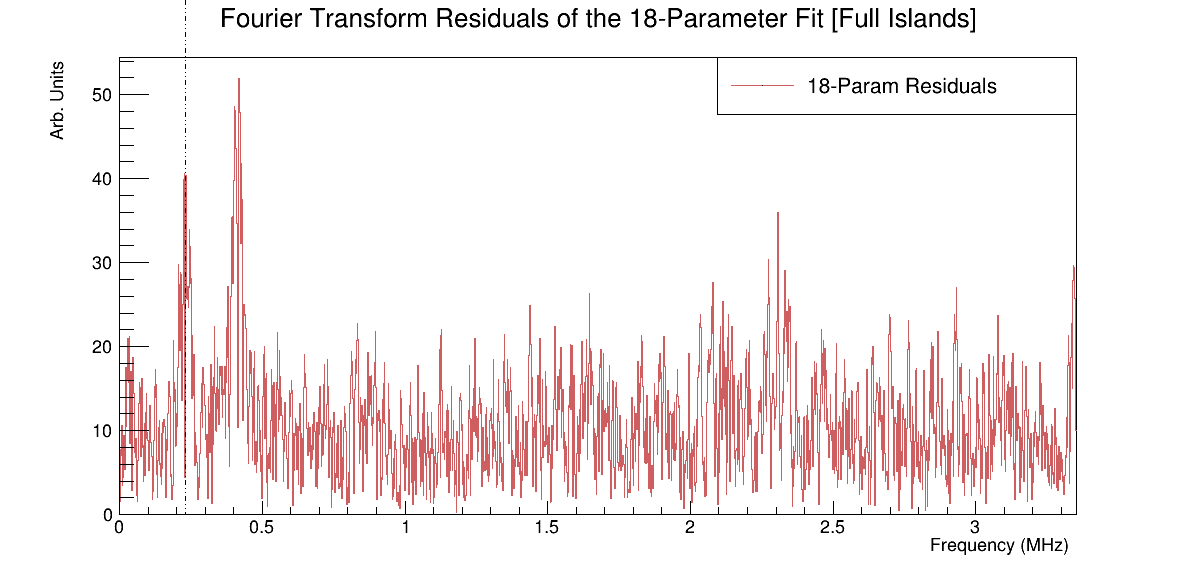

In [46]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
#residuals5paramXform_FullIslands.Draw("hist")
#residuals13paramXform_FullIslands.Draw("hist same")
#residuals17paramXform_FullIslands.Draw("hist same")
residuals18paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
#leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
#leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
#leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.AddEntry(residuals18paramXform_FullIslands,"18-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


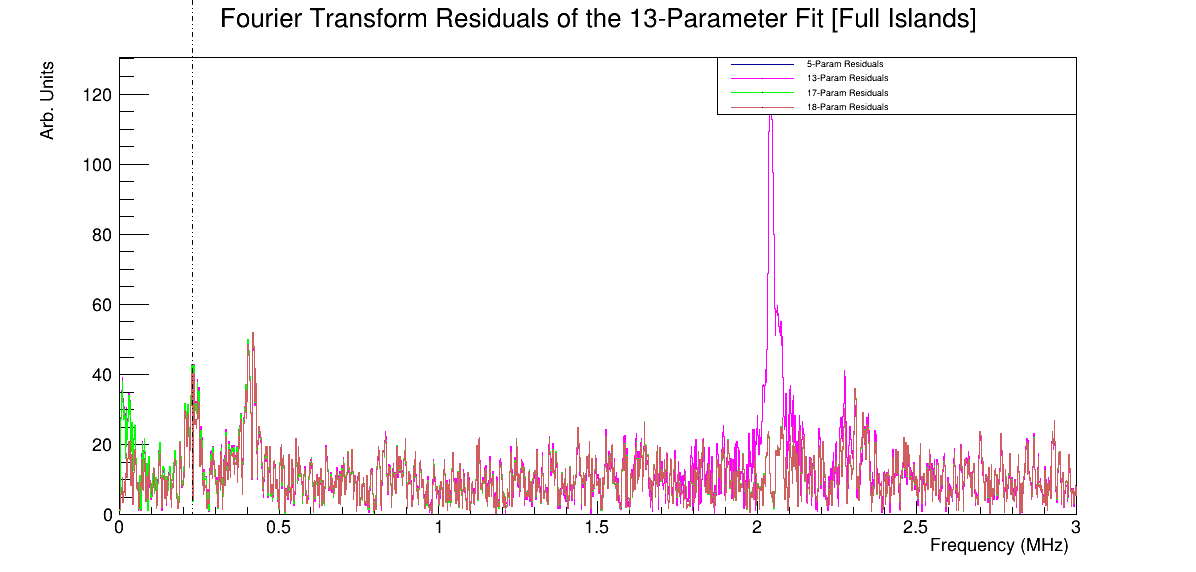

In [47]:
c = r.TCanvas("c","c",1200,600)
residuals13paramXform_FullIslands.GetXaxis().SetRangeUser(0,3)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist ")
residuals17paramXform_FullIslands.Draw("hist same")
residuals18paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.AddEntry(residuals18paramXform_FullIslands,"18-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


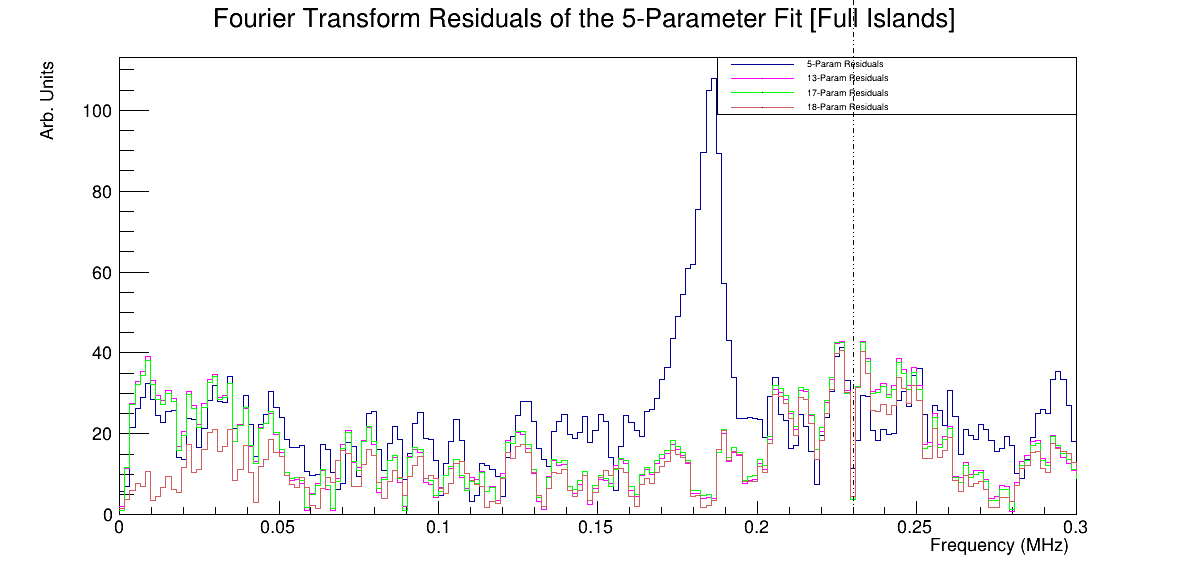

In [48]:
c = r.TCanvas("c","c",1200,600)
residuals5paramXform_FullIslands.GetXaxis().SetRangeUser(0,.3)
residuals5paramXform_FullIslands.Draw("hist")
residuals13paramXform_FullIslands.Draw("hist same")
residuals17paramXform_FullIslands.Draw("hist same")
residuals18paramXform_FullIslands.Draw("hist same")

leg = r.TLegend(0.6,0.8,0.9,0.9)
leg.AddEntry(residuals5paramXform_FullIslands,"5-Param Residuals")
leg.AddEntry(residuals13paramXform_FullIslands,"13-Param Residuals")
leg.AddEntry(residuals17paramXform_FullIslands,"17-Param Residuals")
leg.AddEntry(residuals18paramXform_FullIslands,"18-Param Residuals")
leg.Draw()

f_omega_a.Draw("SAME")

c.Draw()

---

### Now lets get the resisuals from the main function

In [49]:
fresid = r.TFile("./images/Residuals_18Par_Full.root")
fresid.ls()

TFile**		./images/Residuals_18Par_Full.root	
 TFile*		./images/Residuals_18Par_Full.root	
  KEY: TCanvas	c;1	c


In [50]:
c = fresid.Get("c")
print([x for x in c.GetListOfPrimitives()])

[<ROOT.TFrame object ("TFrame") at 0x7fa0b5572a40>, <ROOT.TH1D object ("out_MAG P") at 0x7fa0bd232210>, <ROOT.TPaveText object ("title") at 0x7fa0b5896920>]


In [51]:
hfull = c.GetPrimitive("out_MAG P").Clone("hfull")
hfull.SetDirectory(0)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


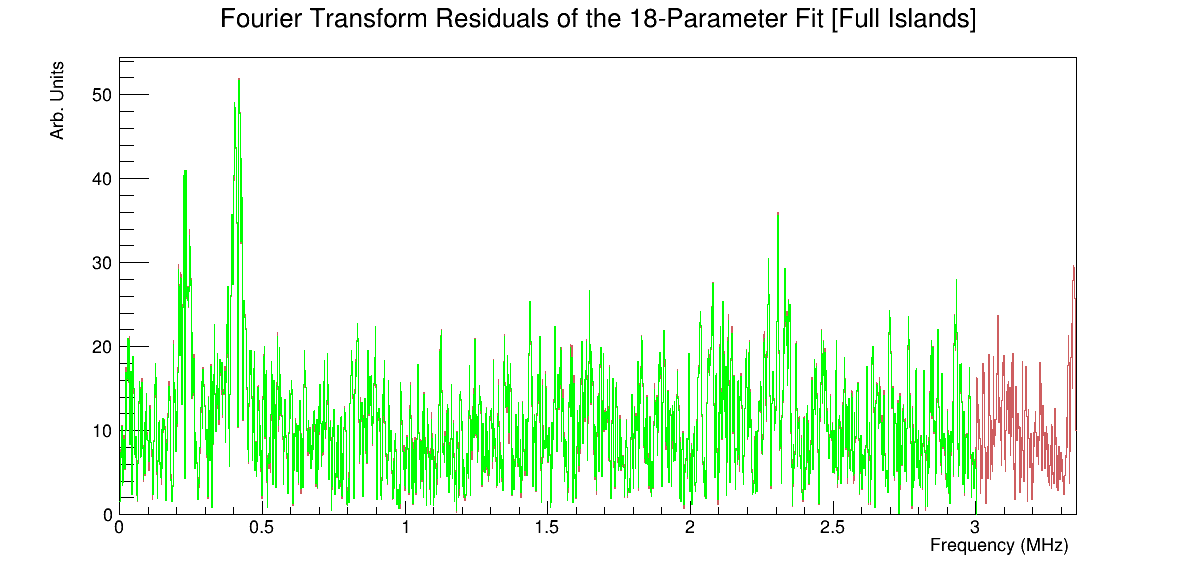

In [54]:
c = r.TCanvas()
residuals18paramXform_FullIslands.Draw("hist")
hfull.Draw("hist SAME")
c.Draw()

In [57]:
hdiff = residuals18paramXform_FullIslands.Clone("hdiff")
hdiff.SetTitle("Difference in Residuals from the 18-Parameter Fit: Missing - Full")
hdiff.Add(hfull, -1)

True

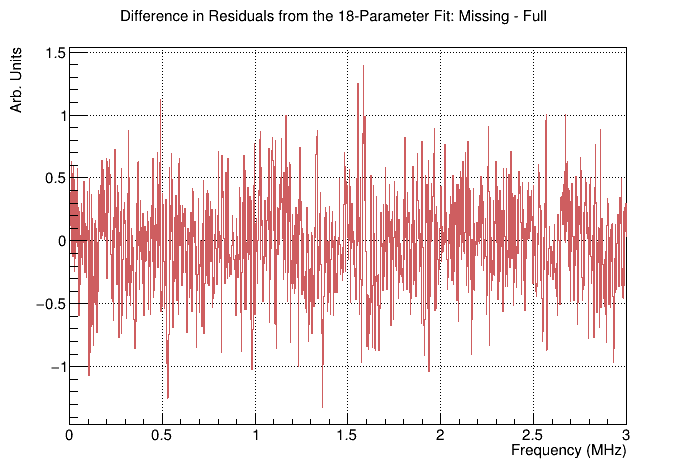

In [61]:
c = r.TCanvas()
hdiff.GetXaxis().SetRangeUser(0,3)
hdiff.Draw("hist")
c.SetGrid()
c.Draw()